In [16]:
## This is the SRCNN method for image super-resolution
## We just use  CIFAR-10 as our training and testing dataset
## The problem is that output images still seem blurry

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             # Number of convolutional layer neurons (convolutional kernels)
    kernel_size=9,          # size
    padding='same',         # padding（vaild or same）
    activation=tf.nn.relu   # active function
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          # no active function 
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')# Create a model
  
model.summary() # see model sunmmary

Model: "SRCNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [11]:
import cv2 as cv
import numpy as np

'''
CIFAR10 had't 128*128*3 images use bicubic alternatived,and bicubic use nearest alternatived.
X_: image applied bicubic interpolation (low-resolution),(50000, 128, 128, 3)
y_: image with original resolution (high-resolution),(10000, 128, 128, 3)
'''

ishape = 128

# load data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

#  Reduce the data set, control the memory consumption (the following Win10, 8G memory available)
train_image = train_images[0:10000]
test_image  = test_images[0:1000]

X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in test_image]) / 255.

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    # compile

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)# train

test_scores = model.evaluate(X_test, y_test, verbose=2) # evaluation

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

# Save entire model to a HDF5 file
model.save('SRCNN.h5')

Epoch 1/3
125/125 [==============================] - 297s 2s/step - loss: 0.3656 - mae: 0.1678 - val_loss: 0.0083 - val_mae: 0.0594
Epoch 2/3
125/125 [==============================] - 264s 2s/step - loss: 0.0050 - mae: 0.0448 - val_loss: 0.0029 - val_mae: 0.0340
Epoch 3/3
125/125 [==============================] - 286s 2s/step - loss: 0.0110 - mae: 0.0593 - val_loss: 0.0032 - val_mae: 0.0384
32/32 - 5s - loss: 0.0032 - mae: 0.0384
Test loss: 0.0031887786462903023
Test mae: 0.038406599313020706


In [31]:
model = tf.keras.models.load_model('SRCNN.h5')

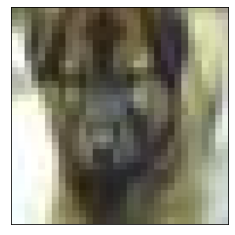

In [32]:
import cv2 as cv
from matplotlib import pyplot as plt

ishape = 128

#load enlarge pictures
img = cv.imread('0004.jpg')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# (36,36,3)->(128,128,3)

plt.imshow(img)

plt.xticks([]), plt.yticks([])
plt.savefig("before0004.png") #store picture before super-resolution
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


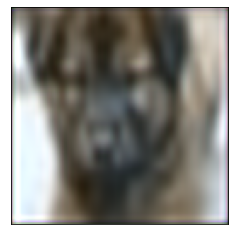

In [33]:
import numpy as np

img = np.reshape(img,(1,ishape,ishape,3)) / 255.

# Processing image super-resolution
img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])
plt.savefig("SRCNN0004.png") # store picture after super-resolution
plt.show()